In [5]:
# Import Libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Load the dataset; Print the first few rows

df = pd.read_csv("depression_dataset_reddit_cleaned.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [ ]:
# Data Cleaning and Preprocessing
# The "depression_dataset_reddit_cleaned.csv" was already cleaned when we got it. 
# However, we think we can further clean it by removing short posts (anything fewer than 5 words <-- This is subject to change later on).
# We also check for and remove duplicate posts.

import re
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from IPython.display import display

# Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# POS tag mapper
# This is important for the lemmatizer to work properly.
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default

# Preprocessing function
def preprocess_text_better(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return " ".join(lemmatized)

# Remove posts with fewer than 5 words
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 5]

# Remove duplicate posts
df = df.drop_duplicates(subset='clean_text')

# Apply preprocessing
df['processed_text'] = df['clean_text'].apply(preprocess_text_better)

# Save as CSV File
df[['clean_text', 'processed_text', 'is_depression']].to_csv("reddit_processed_text_data.csv", index=False)

print("Original dataset size: 7731")
print("Final dataset size after filtering:", df.shape[0])


df[['clean_text', 'processed_text']].head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\miko9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Original dataset size: 7731
Final dataset size after filtering: 7289


,clean_text,processed_text
0,we understand that most people who reply immed...,understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,anyone else instead sleep depressed stay night...
3,i ve kind of stuffed around a lot in my life d...,kind stuffed around lot life delay inevitable ...
4,sleep is my greatest and most comforting escap...,sleep great comfort escape whenever wake day l...


<Figure size 1000x600 with 0 Axes>

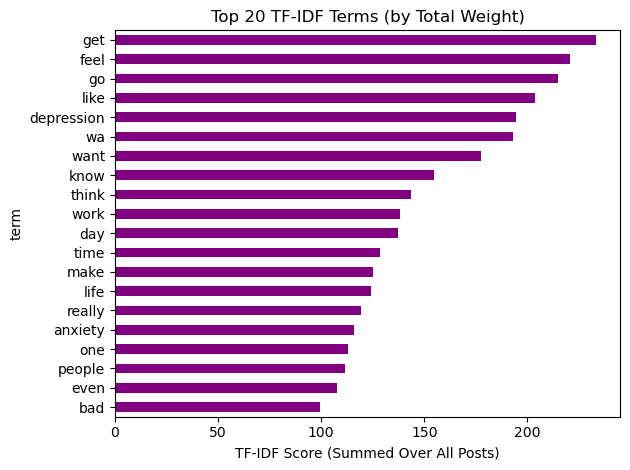

In [12]:
# Feature extraction
import pandas as pd
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_text']).toarray()
y = df['is_depression']

# Get the feature (word) names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Sum the TF-IDF scores for each term across all documents
tfidf_sums = X.sum(axis=0)

# Create a DataFrame for easy sorting and plotting
tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_sum': tfidf_sums})
tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

# Plot the top 20 TF-IDF terms
plt.figure(figsize=(10, 6))
tfidf_df.head(20).plot(kind='barh', x='term', y='tfidf_sum', legend=False, color='purple')
plt.title("Top 20 TF-IDF Terms (by Total Weight)")
plt.xlabel("TF-IDF Score (Summed Over All Posts)")
plt.gca().invert_yaxis()  # Highest score at the top
plt.tight_layout()
plt.show()

In [13]:
# Data Split (train-test splitting)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Load the model 
# For this project, we have decided to use Logistic Regression Model

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Evaluation with threshold = 0.4
Accuracy: 0.9547325102880658
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       707
           1       0.95      0.96      0.96       751

    accuracy                           0.95      1458
   macro avg       0.95      0.95      0.95      1458
weighted avg       0.95      0.95      0.95      1458



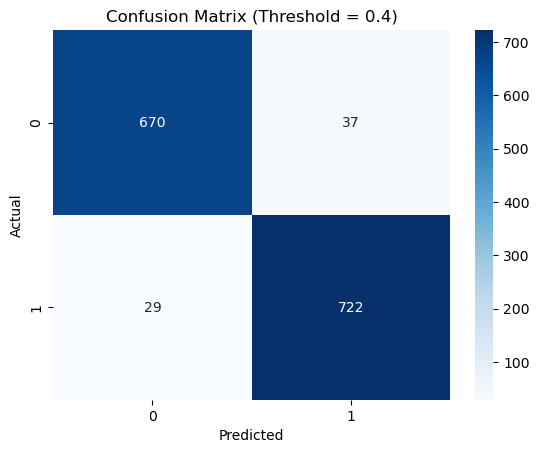

In [15]:
# Load the model 
# For this project, we have decided to use Logistic Regression Model

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# Get probabilities for class 1 (depression)
y_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold to 0.4 (you can experiment with values like 0.45 or 0.35 too)
threshold = 0.4
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluate
print(f"Evaluation with threshold = {threshold}")
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_thresh))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_thresh), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 0.9547325102880658
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       707
           1       0.97      0.94      0.96       751

    accuracy                           0.95      1458
   macro avg       0.95      0.96      0.95      1458
weighted avg       0.96      0.95      0.95      1458



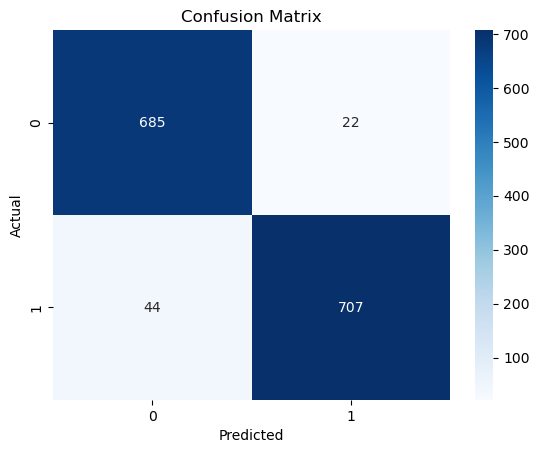

In [16]:
# Evaluate the results 
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Naive Bayes Accuracy: 0.8950617283950617
Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88       707
           1       0.84      0.99      0.91       751

    accuracy                           0.90      1458
   macro avg       0.91      0.89      0.89      1458
weighted avg       0.91      0.90      0.89      1458



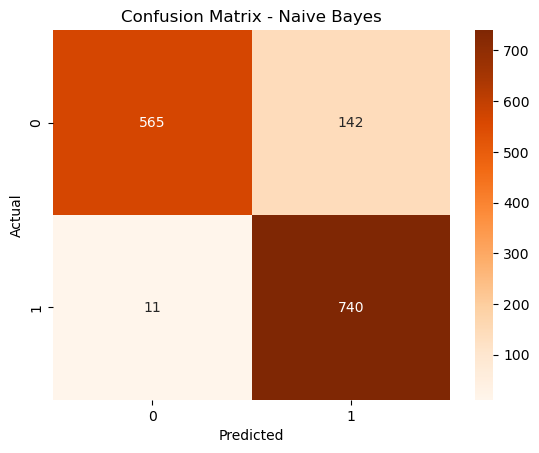

In [17]:
# Try a second model to compare performance

from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_nb_pred = nb_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_nb_pred))
print("Naive Bayes Report:\n", classification_report(y_test, y_nb_pred))

sns.heatmap(confusion_matrix(y_test, y_nb_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
# Define a function to process a new input text

def predict_new_post(text, model):
    # Preprocess like before
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    processed = " ".join(lemmatized)
    
    # TF-IDF transform
    tfidf_input = tfidf.transform([processed]).toarray()
    
    # Predict
    prediction = model.predict(tfidf_input)[0]
    probability = model.predict_proba(tfidf_input)[0][prediction]
    
    label = "Depressed" if prediction == 1 else "Not Depressed"
    print(f"Prediction: {label} (Confidence: {probability:.2f})")


In [19]:
# Logistic Regression to the input sentences
predict_new_post("I feel so tired and empty all the time.", model)
predict_new_post("I believe i can fly really high", model)
predict_new_post("I feel like an empty shell of my former glory", model)
predict_new_post("I am so attracted to attractive people", model)
predict_new_post("No one is going through what I am going through", model)
predict_new_post("I am not interested in meeting new people", model)
predict_new_post("I have no desire in meeting new people", model)

Prediction: Depressed (Confidence: 0.56)
Prediction: Not Depressed (Confidence: 0.77)
Prediction: Not Depressed (Confidence: 0.65)
Prediction: Not Depressed (Confidence: 0.73)
Prediction: Not Depressed (Confidence: 0.86)
Prediction: Not Depressed (Confidence: 0.81)
Prediction: Not Depressed (Confidence: 0.82)


In [20]:
# Use Naive Bayes Model to test the input sentence
predict_new_post("I feel like everything is meaningless.", nb_model)
predict_new_post("I really like going to parties", nb_model)
predict_new_post("I feel like an empty shell of my former glory", nb_model)
predict_new_post("I am not alone, i have many friends", nb_model)
predict_new_post("No one is going through what I am going through", nb_model)
predict_new_post("I am not interested in meeting new people", nb_model)
predict_new_post("I have no desire in meeting new people", nb_model)

Prediction: Depressed (Confidence: 0.87)
Prediction: Not Depressed (Confidence: 0.53)
Prediction: Depressed (Confidence: 0.66)
Prediction: Depressed (Confidence: 0.84)
Prediction: Depressed (Confidence: 0.50)
Prediction: Not Depressed (Confidence: 0.52)
Prediction: Depressed (Confidence: 0.53)
